#  Pivot Table

## 1. Titanic

In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
titanic = sns.load_dataset('titanic')

In [43]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [27]:
# 성별에 따른 생존율

titanic.groupby('sex')[['survived']].mean()

,survived
sex,
female,0.742038
male,0.188908


In [20]:
# 성별과 좌석등급별 생존율 (groupby)

titanic.groupby(['sex', 'class'])['survived'].aggregate('mean').unstack()

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


In [12]:
# 성별과 좌석등급별 생존율 (pivot table)

titanic.pivot_table('survived', index = 'sex', columns = 'class')

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


In [29]:
# 성별, 연령, 좌석등급별 생존율

age = pd.cut(titanic['age'], [0, 18, 80])
titanic.pivot_table('survived', ['sex', age], 'class')

class               First    Second     Third
sex    age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

In [34]:
# 티켓 가격별 성별, 연령, 좌석등급별 생존율

fare = pd.qcut(titanic['fare'], 3)
titanic.pivot_table('survived', ['sex', age], [fare, 'class'])

fare            (-0.001, 8.662]           (8.662, 26.0]                      \
class                     First     Third         First    Second     Third   
sex    age                                                                    
female (0, 18]              NaN  0.700000           NaN  1.000000  0.583333   
       (18, 80]             NaN  0.523810           1.0  0.877551  0.433333   
male   (0, 18]              NaN  0.166667           NaN  0.500000  0.500000   
       (18, 80]             0.0  0.127389           0.0  0.086957  0.102564   

fare            (26.0, 512.329]                   
class                     First Second     Third  
sex    age                                        
female (0, 18]         0.909091    1.0  0.111111  
       (18, 80]        0.972222    1.0  0.125000  
male   (0, 18]         0.800000    0.8  0.052632  
       (18, 80]        0.400000    0.0  0.500000

In [37]:
# 생존율은 합계, 티켓가격은 평균으로 집계

titanic.pivot_table(index = 'sex', columns = 'class', aggfunc = {'survived':sum, 'fare':'mean'})

fare                       survived             
class        First     Second      Third    First Second Third
sex                                                           
female  106.125798  21.970121  16.118810       91     70    72
male     67.226127  19.741782  12.661633       45     17    47

### DataFrame 의 pivot_table method 의 전체 호출 시그니처

DataFrame.pivot_table(data, values=None, index=None, columns=None, aggfunc='mean', fill_value=None, margines=False,
                      dropna = True, margins_name='All')

In [40]:
titanic.pivot_table('survived', index = 'sex', columns = 'class', margins = True)

class,First,Second,Third,All
sex,,,,
female,0.968085,0.921053,0.500000,0.742038
male,0.368852,0.157407,0.135447,0.188908
All,0.629630,0.472826,0.242363,0.383838


## 2. 질병대책본부(CDC, Center for Disease Control) 미국 출생률 데이터

In [ ]:
# 데이터 다운로드를 위한 셸 명령어:
# !curl -0 https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv

In [49]:
births = pd.read_csv('https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv')
births.head()

,year,month,day,gender,births
0,1969,1,1.0,F,4046
1,1969,1,1.0,M,4440
2,1969,1,2.0,F,4454
3,1969,1,2.0,M,4548
4,1969,1,3.0,F,4548


In [51]:
# 연대열을 추가하고 연대별 남녀의 출생수 집계

births['decade'] = 10 * (births['year'] // 10)
births.pivot_table('births', index = 'decade', columns = 'gender', aggfunc = 'sum')

gender,F,M
decade,,
1960,1753634,1846572
1970,16263075,17121550
1980,18310351,19243452
1990,19479454,20420553
2000,18229309,19106428


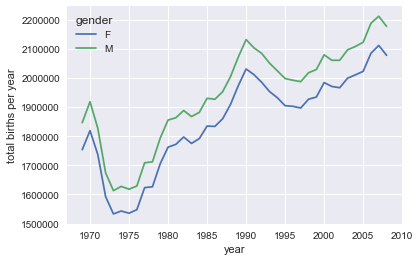

In [58]:
%matplotlib inline
sns.set()
births.pivot_table('births', index = 'year', columns = 'gender', aggfunc = 'sum').plot()
plt.ylabel('total births per year');

지난 50년간 남성의 출생 수가 여성보다 5% 정도 더 높았음을 알 수 있음. 

In [67]:
# 오타나 누락된 값으로 인한 이상치 제거 (시그마 클리핑 연산)

quantiles = np.percentile(births['births'], [25, 50, 75])
# print(quantiles)
mu = quantiles[1]
sig = 0.74 * (quantiles[2] - quantiles[0]) # 평균의 견고한 추정치. 0.74는 가우스 분포의 사분위수에서 비롯
# print(sig)

births = births.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @ sig)')

In [68]:
# 'day' 열을 정수형으로 설정; 원래는 널 값 때문에 문자열 이었음

births['day'] = births['day'].astype(int)

In [70]:
# 년, 월, 일로부터 날짜 인덱스 생성,  요일별 출생수 그래프 그리기

births.index = pd.to_datetime(10000 * births.year + 
                              100 * births.month +
                              births.day, format = '%Y%m%d')
births['dayofweek'] = births.index.dayofweek

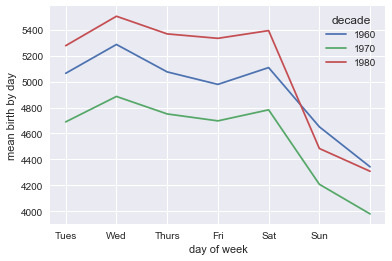

In [75]:
births.pivot_table('births', index = 'dayofweek', columns = 'decade', aggfunc = 'mean').plot()
plt.gca().set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.xlabel('day of week')
plt.ylabel('mean birth by day');

출생수가 주중보다 주말에 약간 더 낮은 것읋 확인할 수 있음 (1989년을 기점으로 태어난 연월만 포함하고 있기 때문에 1990년대와 2000년대는 그래프가 없음 )

In [76]:
# 연도내 일별 평균 출생수를 그래프로 나타냄 

births_by_date = births.pivot_table('births', [births.index.month, births.index.day]) # 월과 일을 가지는 다중인덱스를 얻음
births_by_date.head()

births
1 1  4009.225
  2  4247.400
  3  4500.900
  4  4571.350
  5  4603.625

In [ ]:
births_by_date.index = [pd.datetime(2012, month, day)
                        for (month, day) in births_by_date.index]

In [88]:
births_by_date.head()

,births
2012-01-01,4009.225
2012-01-02,4247.400
2012-01-03,4500.900
2012-01-04,4571.350
2012-01-05,4603.625


Text(0.5,1,'날짜별 일평균 출생 수')

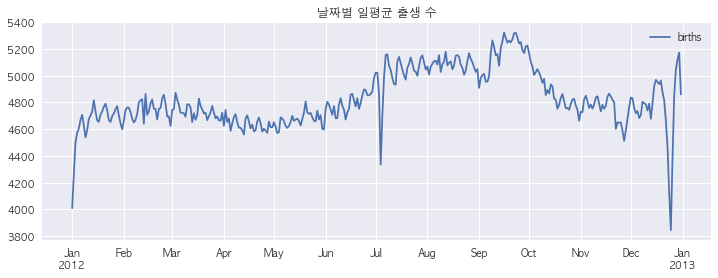

In [96]:
fig, ax = plt.subplots(figsize=(12, 4))
births_by_date.plot(ax=ax);
plt.title('날짜별 일평균 출생 수')